<a href="https://colab.research.google.com/github/geminiwaldo/CMP419-Weekly-Labs/blob/main/CMP419_lab3_text_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*The original version of this code was written by me in TensorFlow and converted this year to PyTorch using an LLM, with some manual tweaks and fixes.*

If there is any part of the code you do not understand, please ask in the lab or look it up if you prefer.

# Week 3 Lab: Text Representation and Sentiment Classification

In this lab, you will explore how text can be converted into numerical representations for machine learning. You will build a simple sentiment classifier using different text representations, and observe how the choice of representation affects model performance.


In [2]:
# imports
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from datasets import load_dataset
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

We will use the [IMDB dataset](https://huggingface.co/datasets/stanfordnlp/imdb) of movie reviews. Look at the structure of the dataset to understand what components are being used. Each review is just raw text and is labeled as either positive or negative.

You can use a subset for faster processing.

In [3]:
# Load IMDb dataset
dataset = load_dataset("imdb")

# Use a subset: 80% train, 20% test
train_data = dataset["train"].shuffle(seed=42).select(range(20000))
test_data  = dataset["train"].shuffle(seed=42).select(range(20000, 25000))

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Look at a few random reviews and their labels.

In [4]:
# Inspect a few samples
indices = random.sample(range(len(train_data)), 3)
for i in indices:
    print("Label:", train_data[i]["label"])
    print(train_data[i]["text"][:300], "...")
    print("-" * 40)

Label: 1
It's actually a good thing Sean Connery retired as James Bond, as I'm sure he wouldn't be able to keep up in the nowadays spying-business, where fast cars have been replaced with hi-tech brainwashing techniques and gorgeous women are considered to be less sexy than advanced computer equipment. "Cyph ...
----------------------------------------
Label: 0
As usual, i went to watch this movie for A.R.Rahman. Otherwise, the film is no good. Rajni wanted to end his movie career with this film is it would be successful. But fortunately or unfortunately the film was a failure. After this he delivered a hit with Chandramukhi. I Am eagerly waiting for his f ...
----------------------------------------
Label: 1
This is a good family show with a great cast of actors. It's a nice break from the reality show blitz of late. There is nothing else quite like it on television right now either, unless you count Joan of Arcadia as being similar because it has a teen lead character too. Anyway, Cl

The `analyse_text_split` helper function shows average/max review lengths and label distribution.

In [5]:
# Function to compute dataset statistics
def analyse_text_split(data_split, split_name):
    # Compute the number of tokens in each text sample
    lengths = [len(example["text"].split()) for example in data_split]

    # Print basic statistics about text length
    print(f"{split_name} split:")
    print(f"Average length: {np.mean(lengths):.1f} tokens")
    print(f"Max length: {np.max(lengths)} tokens")

    # Count how many samples belong to each label (0 = negative, 1 = positive)
    label_counts = Counter(data_split["label"])

    # Visualise the label distribution
    plt.bar(["Negative", "Positive"], [label_counts[0], label_counts[1]])
    plt.title(f"{split_name} Label Distribution (IMDb)")
    plt.show()

Training split:
Average length: 233.6 tokens
Max length: 2470 tokens


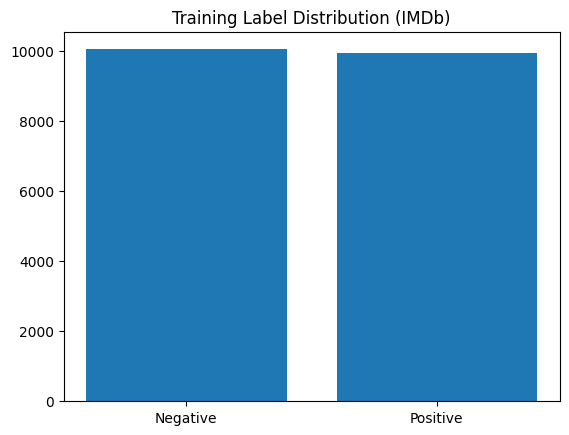

Testing split:
Average length: 234.7 tokens
Max length: 1830 tokens


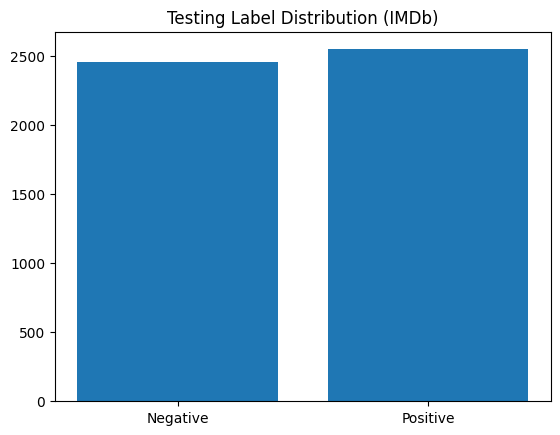

In [5]:
# TODO: call the function to inspect the training and testing folds
analyse_text_split(train_data, "Training") # remove
analyse_text_split(test_data, "Testing") # remove

# Sparse Text Representation

Sparse representation means most entries are zero. In the lecture, we saw examples of one-hot encoding, BOW, and TF-IDF encoding. We will use BOW and TF-IDF. These sparse representations capture word occurrence or weighted importance but ignore word order and context.

*Bag-of-Words*: creates a sparse matrix where the count of each word that appears in a document is included as the feature.

*Term-Frequency Inverse Document Frequency*: creates features for each document based on how often each word shows up in a document versus the entire corpus. A document here being a review.

Both techniques are available from `sklearn.feature_extraction.text` package. A vectorizer is used like a classifier that needs fitting to the dataset before vectorizing the words. Its general usage looks like this:
```
vectorizer = VectorizerType(your_settings)
vectorizer.fit(your_dataset)
vec = vectorizer.transform('your_text')
```
The settings allows us to change its parameters. For example, setting the `max_features=1000` limits the number of words taken into consideration and only the `1000` most occuring words are used for building the sparse vector, excluding all rare words, and resulting a vector of dimension `1000` per word. Also, setting `ngram_range=(1,n)`specifies the size of n-grams used when building the vector. So `(1,1)` means unigram (one word is used to encode) and `(1,3)` uses from one to three words to encode etc.

The vectorizer already lowercases text by default. It also tokenises and removes punctuation internally. With `stop_words="english"`, common stopwords are removed.







## BOW

In [6]:
# BOW (CounterVectorizer)
n_features = None # means all features will be used

vectorizer_bow = CountVectorizer(max_features=n_features, stop_words='english')
X_train_bow = vectorizer_bow.fit_transform([ex["text"] for ex in train_data])
X_test_bow  = vectorizer_bow.transform([ex["text"] for ex in test_data])

print("Bag-of-Words features shape:", X_train_bow.shape)

Bag-of-Words features shape: (20000, 67915)


## Visualise BOW Representations

To have an idea of what the sparse representation looks like, we display a few samples.


In [7]:
# Pick 3 random samples
sample_indices = random.sample(range(len(train_data)), 3)

for idx in sample_indices:
    text = train_data[idx]["text"][:100] + "..."
    label = train_data[idx]["label"]
    print(f"\nSample index {idx} | Label: {label} | Text: {text}\n")

    # Bag-of-Words
    bow_vector = X_train_bow[idx].toarray()[0]
    nonzero_idx = np.flatnonzero(bow_vector)[:10]  # first 10 non-zero features
    words = vectorizer_bow.get_feature_names_out()[nonzero_idx]
    counts = bow_vector[nonzero_idx]

    # pandas DataFrame, with columns Word vs Count, making it visually cleaner
    df_bow = pd.DataFrame({"Word": words, "Count": counts})
    print("Bag-of-Words (first 10 non-zero features):")
    print(df_bow.to_string(index=False))


Sample index 1490 | Label: 0 | Text: The book that this movie is based on seriously changed my life. But saying this movie was a disappoi...

Bag-of-Words (first 10 non-zero features):
          Word  Count
        acting      1
         based      1
          book      5
         bunch      1
     celestine      1
       central      1
       changed      1
cinematography      1
    components      1
     countless      1

Sample index 421 | Label: 1 | Text: "Return of the Jedi" is often remembered for what it did wrong rather than what it did right, and th...

Bag-of-Words (first 10 non-zero features):
         Word  Count
   annoyances      2
     arguably      2
        bears      1
         best      1
          bit      1
           br      6
      broaden      1
      chapter      1
chronological      1
       cinema      1

Sample index 18220 | Label: 0 | Text: this movie begins with an ordinary funeral... and it insists so hard on this ordinary funeral feel t...

Bag-of-Words

## TF-IDF

Create a TF-IDF vectorizer (similar to CountVectorizer above) and display some sample representations. Observe the differences in the outputs compared to the BOW.


In [17]:
# TODO: TF-IDF vectorizer
n_features = None # means all features will be used

vectorizer_tfidf = TfidfVectorizer(max_features=100, ngram_range=(1,1), stop_words='english')
X_train_tfidf = vectorizer_tfidf.fit_transform([ex["text"] for ex in train_data])
X_test_tfidf = vectorizer_tfidf.transform([ex["text"] for ex in test_data])

num_features = len(vectorizer_tfidf.get_feature_names_out())
print(num_features)


print("TF-IDF features shape:", X_train_tfidf.shape)

100
TF-IDF features shape: (20000, 100)


In [12]:
# TODO: show some TF-IDF samples
# Pick 3 random samples
sample_indices = random.sample(range(len(train_data)), 3)

for idx in sample_indices:
    text = train_data[idx]["text"][:100] + "..."
    label = train_data[idx]["label"]
    print(f"\nSample index {idx} | Label: {label} | Text: {text}\n")

    # TF-IDF
    tfidf_vector = X_train_tfidf[idx].toarray()[0]
    nonzero_idx = np.flatnonzero(tfidf_vector)[:10]  # first 10 non-zero features
    words = vectorizer_tfidf.get_feature_names_out()[nonzero_idx]
    counts = tfidf_vector[nonzero_idx]

    # pandas DataFrame, with columns Word vs Count, making it visually cleaner
    df_tfidf = pd.DataFrame({"Word": words, "Count": counts})
    print("TF-IDF (first 10 non-zero features):")
    print(df_tfidf.to_string(index=False))


Sample index 18845 | Label: 0 | Text: Jill Dunne (played by Mitzi Kapture), is an attractive, nice woman, over-whelmed by a smart-mouthed ...

TF-IDF (first 10 non-zero features):
     Word    Count
      bit 0.060804
       br 0.911521
character 0.048920
     does 0.049958
    doesn 0.163077
      end 0.050304
     fact 0.231569
   family 0.128758
      far 0.060922
     film 0.088187

Sample index 17234 | Label: 1 | Text: I'm gonna tip the scales here a bit and say I enjoyed this. However, the cartoon is really only goin...

TF-IDF (first 10 non-zero features):
     Word    Count
      bit 0.169558
       br 0.635466
character 0.136418
    going 0.310357
     just 0.096429
     kind 0.175532
     love 0.140636
   people 0.123623
    point 0.503618
 probably 0.172646

Sample index 5179 | Label: 1 | Text: First let me say that Before Sunrise, like all movies, is NOT a movie for all tastes. It appears som...

TF-IDF (first 10 non-zero features):
  Word    Count
    br 0.520932
  fact 0

In [16]:
"""
bow_model = LogisticRegression(max_iter=1000)
y_train_bow = [ex["label"] for ex in train_data]
bow_model.fit(X_train_bow, y_train_bow)

y_test_bow = [ex["label"] for ex in test_data]
y_pred_bow = bow_model.predict(X_test_bow)

print("BoW Accuracy:", accuracy_score(y_test_bow, y_pred_bow))
print("\nBoW Classification Report:\n")
print(classification_report(y_test_bow, y_pred_bow))
"""
# ==============================================================================

tfidf_model = LogisticRegression(max_iter=1000)
y_train_tfidf = [ex["label"] for ex in train_data]
tfidf_model.fit(X_train_tfidf, y_train_tfidf)

y_test_tfidf = [ex["label"] for ex in test_data]
y_pred_tfidf = tfidf_model.predict(X_test_tfidf)

print("tfidf Accuracy:", accuracy_score(y_test_tfidf, y_pred_tfidf))
print("\ntfidf Classification Report:\n")
print(classification_report(y_test_tfidf, y_pred_tfidf))

tfidf Accuracy: 0.8852

tfidf Classification Report:

              precision    recall  f1-score   support

           0       0.89      0.88      0.88      2454
           1       0.88      0.89      0.89      2546

    accuracy                           0.89      5000
   macro avg       0.89      0.89      0.89      5000
weighted avg       0.89      0.89      0.89      5000



# Pre-trained Embeddings

Word embeddings are a different representations that encodes text in the form of dense vectors. A step up, we replace the sparse vectorizers with pre-trained embeddings, such as [Sentence-BERT (MiniLM)](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2) from `sentence-transformers`. This allows us to use dense vector representations that encode semantic meaning and similarity between words and sentences.


In [ ]:
#!pip install -q sentence-transformers # run this only if you have an error importing

from sentence_transformers import SentenceTransformer

embed_model = SentenceTransformer('all-MiniLM-L6-v2')

# takes ~2 min on GPU
X_train_embed = embed_model.encode([ex["text"] for ex in train_data], show_progress_bar=True)
X_test_embed  = embed_model.encode([ex["text"] for ex in test_data], show_progress_bar=True)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/625 [00:00<?, ?it/s]

Batches:   0%|          | 0/157 [00:00<?, ?it/s]

## Visualise Sample Embeddings

This is a heavily documented helper function to display embeddings.

In [ ]:
def display_embedding_samples(X_embed, indices=None, n_digits=3):
  """
  Display a subset of pre-trained embeddings as a DataFrame.
  Parameters:
  - X_embed: numpy array or tensor (num_samples x embedding_dim)
  - indices: list of sample indices to display (default first 3)
  - n_digits: number of decimals to round
  """
  # If no specific sample indices are provided, display the first 3 samples
  if indices is None:
    indices = list(range(min(3, X_embed.shape[0])))
    # Ensure the data is a NumPy array
    # - If already a NumPy array, use it directly
    # - If a PyTorch tensor (on CPU or GPU), convert it to NumPy
    X_dense = X_embed[indices] if isinstance(X_embed, np.ndarray) else X_embed.cpu().numpy()

    # Create column names for the embedding dimensions
    # e.g., Dim_0, Dim_1, ..., Dim_n
    cols = [f"Dim_{i}" for i in range(X_dense.shape[1])]

    # Convert to a DataFrame for a readable tabular format
    df = pd.DataFrame(X_dense, columns=cols)

    # Label the rows with sample numbers
    df.index = [f"Sample {i}" for i in indices]

    # Display the DataFrame
    # Students can now see the embedding values for each selected sample
    display(df)

In [ ]:
# TODO call the function to show some samples
display_embedding_samples(X_train_embed)

,Dim_0,Dim_1,Dim_2,Dim_3,Dim_4,Dim_5,Dim_6,Dim_7,Dim_8,Dim_9,...,Dim_374,Dim_375,Dim_376,Dim_377,Dim_378,Dim_379,Dim_380,Dim_381,Dim_382,Dim_383
Sample 0,0.041117,-0.099860,-0.052069,-0.023226,-0.002253,0.071531,-0.031287,0.025477,0.070469,-0.055660,...,0.070827,0.006891,-0.107010,0.065938,-0.010344,0.022476,0.028474,0.028924,0.059020,0.026620
Sample 1,-0.107422,-0.015334,-0.023237,-0.039290,-0.066939,0.080879,-0.020806,0.037376,0.031979,-0.057476,...,0.044184,0.071759,-0.018064,0.042018,0.006545,0.001440,0.104571,0.055755,0.011248,-0.027618
Sample 2,-0.038099,0.041234,-0.060347,-0.084296,-0.005634,0.089829,0.022043,0.008300,0.059485,-0.004400,...,0.040476,-0.010903,-0.026994,0.049274,0.068961,0.004614,-0.006135,0.034739,-0.033250,-0.010769


# Training and Evaluating a Simple Sentiment Classifier

We have a prepared set of word representations that can be used as features for a classifier. We choose logistic regression as it is fast, interpretable, and sufficient to illustrate the effect of representation. There is will be a trade-off between the number of features, training time, and accuracy. This is part of the summative task this week.

# More resources

* Explore [articles](https://www.kaggle.com/competitions/word2vec-nlp-tutorial/overview/description) around BOW and Word2Vec.
* See an excellent [explanation](https://jalammar.github.io/illustrated-word2vec/) and visualisation of word embeddings and similarity.
* [GloVe](https://huggingface.co/sentence-transformers/average_word_embeddings_glove.6B.300d)
* [Paraphrase MiniLM](https://huggingface.co/sentence-transformers/paraphrase-MiniLM-L6-v2)